In [8]:
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
import  calculation   as cal
import os
from scipy.sparse import random
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import peak_signal_noise_ratio as psnr
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3,4" # specify which GPU(s) to be used
bm.disable_gpu_memory_preallocation()
bm.set_platform('gpu')


In [9]:
class BaseExpSyn(bp.SynConn):
    def __init__(self, pre, post, conn, g_max=1.0, tau=1.0, method='rk2'):
        super(BaseExpSyn, self).__init__(pre=pre, post=post, conn=conn)

        # check whether the pre group has the needed attribute: "spike"
        self.check_pre_attrs('spike')

        # check whether the post group has the needed attributes: "input" and "V"
        self.check_post_attrs('input', 'V')

        # parameters
        self.tau = tau
        self.g_max = g_max
        self.spike_matrix = self.pre.cross

        # integral function
        self.integral = bp.odeint(lambda g, t: -g / self.tau, method=method)

class ExpConnMat(BaseExpSyn):
    def __init__(self, *args, **kwargs):
        super(ExpConnMat, self).__init__(*args, **kwargs)

        # connection matrix
        self.conn_mat = self.conn.require('conn_mat').astype(float)

        # synapse gating variable
        # -------
        # NOTE: Here the synapse number is the same with
        #       the post-synaptic neuron number. This is
        #       different from the AMPA synapse.
        self.g = bm.Variable(bm.zeros(self.post.num))

    def update(self, tdi):
        _t, _dt = tdi.t, tdi.dt
        # integrate the synapse state
        self.g.value = self.integral(self.g, _t, dt=_dt)
        # update synapse states according to the pre spikes
        # get the post-synaptic current
        post_sps = bm.dot(self.spike_matrix.astype(float), self.g_max)
        self.g += post_sps
        self.post.input += self.g

In [10]:
def g_exp(x, gamma):
    return gamma * bm.exp(-gamma*x)

def g_log(x):
    return 1 / (x + 1)

def g_arc(x):
    return 1 / (x**2 + 1)

class IF(bp.NeuGroupNS):
    def __init__(self, size, b, g_function, **kwargs):
        super(IF, self).__init__(size, **kwargs)
        self.V = bm.Variable(bm.zeros(size))
        self.spike = bm.Variable(bm.zeros(size, dtype=bool))
        self.input = bm.Variable(bm.zeros(size))
        self.g_function = g_function
        self.cross = bm.Variable(bm.zeros(size))
        self.b = b

    def update(self):
        dt = bp.share.load('dt')
        t  = bp.share.load('t')
        V = self.V + dt * (self.b + self.input)
        self.spike.value = V >= 1.
        dt_cross = bm.where(self.spike > 0., dt * (1 - self.V)/(V - self.V), 0.)
        self.cross.value = bm.where(self.spike >0., bm.exp(dt_cross -dt), 0.)
        self.V.value = bm.where(self.spike > 0., 0. - (dt_cross - dt) * (self.b + self.input)  , V)
        self.input[:] = 0


class SLCA_multiple(bp.DynamicalSystemNS):
    def __init__(self, num, w, b, lamb, g_function, method='rk2', **kwargs):
        super(SLCA_multiple, self).__init__( **kwargs)

        num_neuron = int(num)
        self.N = IF(num_neuron, b ,g_function)
        self.lamb = lamb
        self.g_function = g_function
        self.firing_rate = bm.Variable(bm.zeros(num_neuron))
        self.N2N = ExpConnMat(pre=self.N,
                        post=self.N,
                        conn= bp.connect.All2All(),
                        tau=1.,
                        g_max= -w,method=method)
        # self.N2N = bp.synapses.Exponential(pre=self.N,
        #                                   post=self.N,
        #                                   conn=bp.connect.All2All(),
        #                                   g_max=-w,
        #                                   tau=1.,
        #                                   output=bp.synouts.CUBA())

    def update(self):
        t, dt = bp.share.load('t'), bp.share.load('dt')
        self.N2N()
        self.firing_rate.value = self.firing_rate * t / (t + dt) + self.N.spike/ (t + dt)
        self.N.input -= self.lamb * self.g_function(self.firing_rate)
        self.N()

In [11]:
import time
def measure_execution_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # 记录开始时间
        result = func(*args, **kwargs)  # 执行要测量运行时间的代码块
        end_time = time.time()  # 记录结束时间
        execution_time = end_time - start_time  # 计算运行时间
        print("Execution Time: {:.6f} seconds".format(execution_time))
        return result, execution_time
    return wrapper
@measure_execution_time
def measure_runner_time(runner, total_period):
    runner.run(total_period)

In [30]:
# 定义您想要测试的正则化参数列表
l_values = [1e-3, 1.78e-3, 3.16e-3, 5.62e-3, 1e-2, 1.78e-2, 3.16e-2, 5.62e-2, 1e-1, 1.78e-1, 3.16e-1, 5.62e-1, 1]
# l_values = [1e-3, 2e-3, 4.6e-3, 1e-2, 2e-2, 4.6e-2, 1e-1, 2e-1, 4e-1, 1]

# 定义您想要测试的正则化参数列表

# 固定稀疏度
sparsity = 0.2  # 您可以根据需要调整稀疏度的值

# 初始化结果矩阵，维度为 (算法数量, l 值数量)
non_zero_counts_matrix = np.zeros((4, len(l_values)))

rng = np.random.RandomState(25)
m, n = 750, 1200
# m, n = 7500, 10000
A = rng.randn(m, n)
A_norm = np.linalg.norm(A, ord=2, axis=0, keepdims=True)
A = A / A_norm

# 生成固定的 x0
x0 = rng.rand(n)
x0[x0 < (1 - sparsity)] = 0
b_np = np.dot(A, x0)
b = np.dot(A.T, b_np)
w = np.dot(A.T, A)
w[np.diag_indices_from(w)] = 0
w = bm.array(w)
b = bm.array(b)
for l_idx, l in enumerate(l_values):

    net_lasso = SLCA_multiple(w.shape[0], w, b, l, lambda x: 1)
    net_exp = SLCA_multiple(w.shape[0], w, b, l, lambda x: g_exp(x, gamma=1))
    net_log = SLCA_multiple(w.shape[0], w, b, l, g_log)
    net_atan = SLCA_multiple(w.shape[0], w, b, l, g_arc)

    total_period = 100
    runner_pars = dict(monitors=['N.spike'], dt=0.1, progress_bar=False)
    runner_lasso = bp.DSRunner(net_lasso, **runner_pars)
    runner_exp = bp.DSRunner(net_exp, **runner_pars)
    runner_log = bp.DSRunner(net_log, **runner_pars)
    runner_atan = bp.DSRunner(net_atan, **runner_pars)

    runner_lasso.run(total_period)
    runner_exp.run(total_period)
    runner_log.run(total_period)
    runner_atan.run(total_period)

    # non_zero_counts_matrix[:, l_idx] = np.array([
    #     np.count_nonzero(np.sum(runner_method.mon['N.spike'][500:]/ total_period, axis=0) > l)
    #     for runner_method in [runner_lasso, runner_exp, runner_log, runner_atan]
    # ], dtype=np.float64)
    non_zero_counts_matrix[:, l_idx] = np.array([
        np.count_nonzero(np.sum(runner_method.mon['N.spike'][300:] / total_period, axis=0))
        for runner_method in [runner_lasso, runner_exp, runner_log, runner_atan]
    ], dtype=np.float64)
bp.math.clear_buffer_memory()


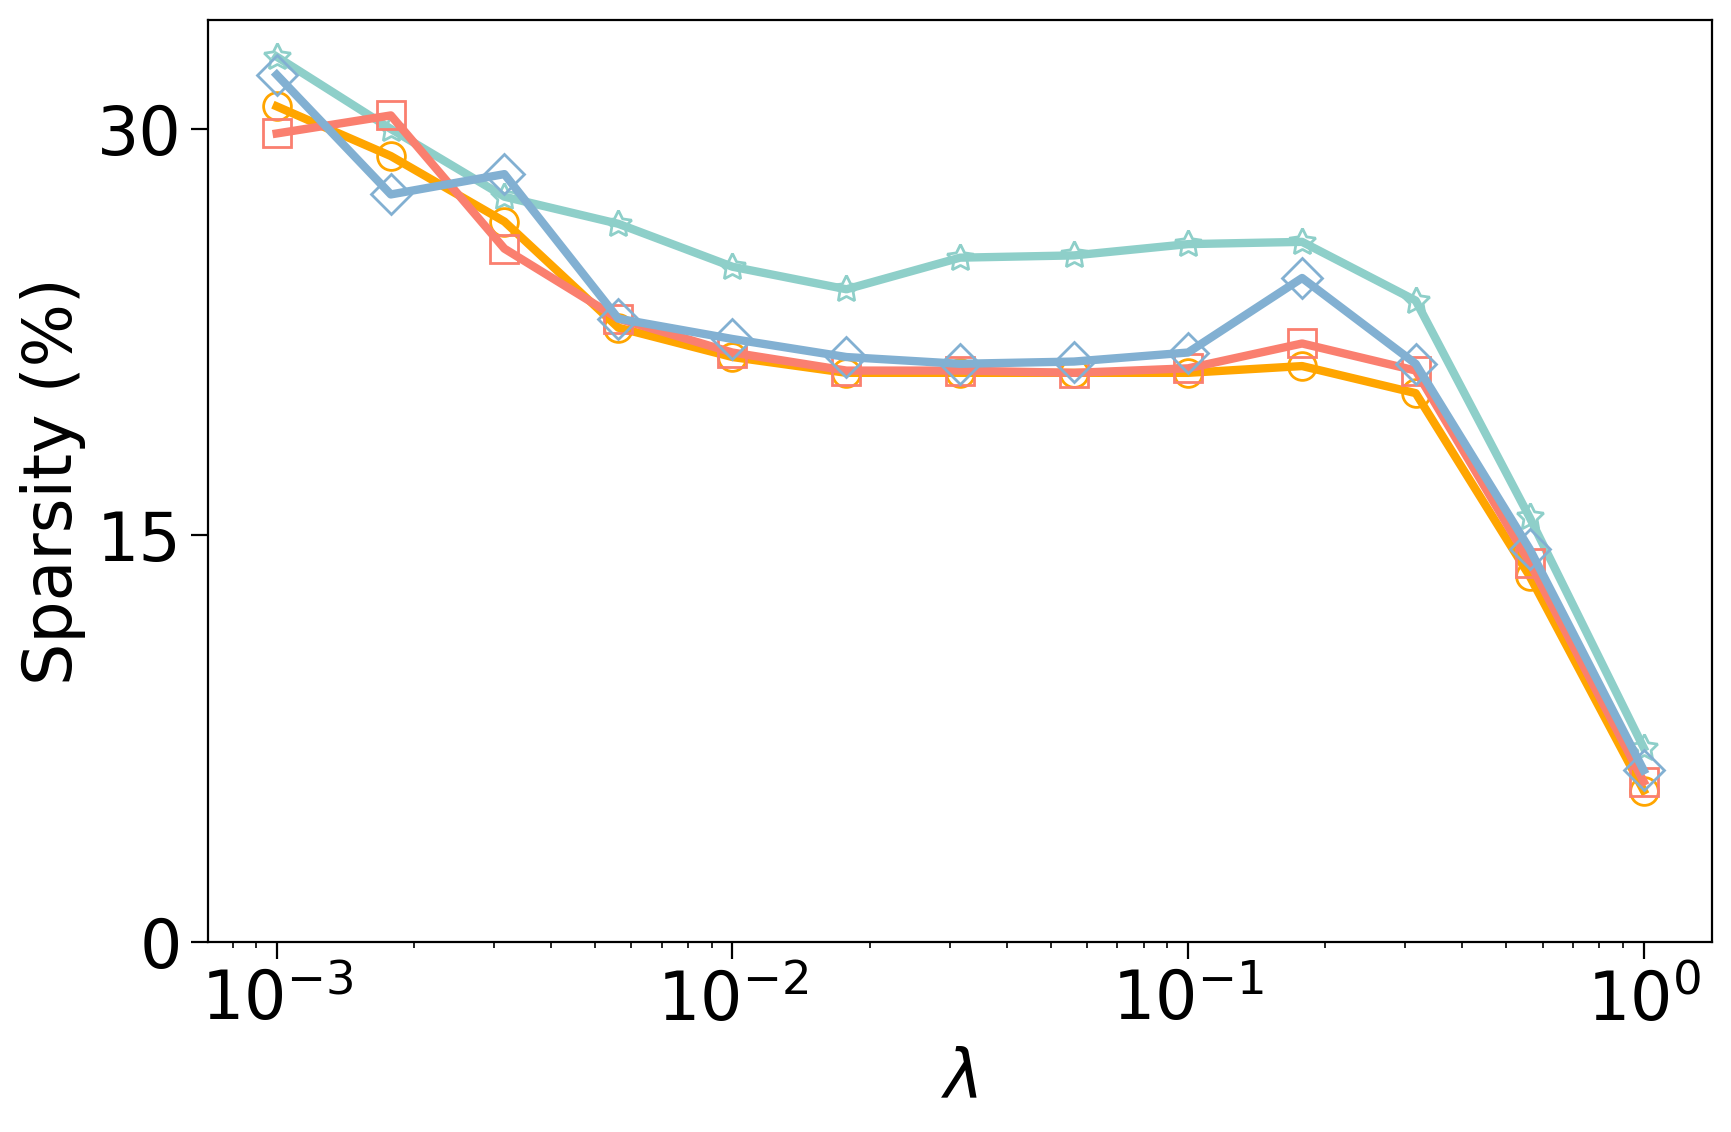

In [33]:
colors = ['#8ECFC9',  "#FFA500", '#FA7F6F', '#82B0D2','#BEB8DC','#E7DAD2']
# colors   = ['#2878b5', '#9ac9db', '#f8ac8c', '#c82423','#ff8884']
markers = [(5,1), 'o', 's', 'D','*']

plt_style = {
    'figure.autolayout' : True,
    'font.size' : 18,
    'lines.linewidth' : 3,
    'xtick.labelsize' : 'medium',
    'ytick.labelsize' : 'medium',
    'legend.fontsize' : 'small',
    # 'axes.spines.top' : False,
    # 'axes.spines.right' : False,
    'xtick.labelsize' : 24,
    'ytick.labelsize' : 24,
    'xtick.major.size' : 6,
    'ytick.major.size' : 6,
    'legend.fontsize' : 18,
    'axes.labelsize' : 24,
    'axes.titlesize' : 24,
    'lines.markersize' : 10,
    # 'font.family': "Times New Roman"
    }
for key, val in plt_style.items():
    plt.rcParams[key] = val

non_zero_counts_matrix_plot = non_zero_counts_matrix / n * 100
# x_ticks = sparsity * 100
# x_tick_labels = ['{:.0f}%'.format(x) for x in x_ticks]
# Select every other label for x-ticks
plt.figure(figsize=(9,6))
plt.plot(l_values, non_zero_counts_matrix_plot[0,:], color=colors[0], marker=markers[0], markerfacecolor='none', label='SLCA-LASSO',)
plt.plot(l_values, non_zero_counts_matrix_plot[1,:], color=colors[1], marker=markers[1], markerfacecolor='none', label='SLCA-Exp')
plt.plot(l_values, non_zero_counts_matrix_plot[2,:], color=colors[2], marker=markers[2], markerfacecolor='none', label='SLCA-Log')
plt.plot(l_values, non_zero_counts_matrix_plot[3,:], color=colors[3], marker=markers[3], markerfacecolor='none', label='SLCA-Atan')
# plt.legend()
# plt.xticks(sparsity, x_tick_labels)
# plt.ylim([-23,-10])
# plt.ylim([-23,1])
plt.yticks([0, 15, 30])
plt.xlabel(r'$\lambda$')
plt.ylabel('Sparsity (%)')
plt.xscale('log')
plt.savefig('Figure/lambda_sparsity.pdf', format='pdf')
plt.savefig('Figure/lambda_sparsity.png', format='png')


In [17]:
# np.savez('Figure/Fig5b.npz', NMSE_matrix=NMSE_matrix, sparsity=sparsity)